In [1]:
import bayes3d as b
import os
import jax.numpy as jnp
import jax
import bayes3d.genjax
import numpy as np
import genjax
import matplotlib
import pathlib
from tqdm import tqdm
import matplotlib.pyplot as plt

In [ ]:
# import flax.linen as nn
# from flax.training import train_state
# from clu import metrics
# import flax
# import optax

In [2]:
b.setup_visualizer()

You can open the visualizer by visiting the following URL:
http://127.0.0.1:7040/static/


In [21]:
intrinsics = b.Intrinsics(
    height=100,
    width=100,
    fx=200.0, fy=200.0,
    cx=50.0, cy=50.0,
    near=0.0001, far=2.0
)

b.setup_renderer(intrinsics)
# model_dir = os.path.join(b.utils.get_assets_dir(),"bop/ycbv/models")
# meshes = []
# for idx in range(1,22):
#     mesh_path = os.path.join(model_dir,"obj_" + "{}".format(idx).rjust(6, '0') + ".ply")
#     b.RENDERER.add_mesh_from_file(mesh_path, scaling_factor=1.0/1000.0)
# b.RENDERER.add_mesh_from_file(os.path.join(b.utils.get_assets_dir(), "sample_objs/cube.obj"), scaling_factor=1.0/1000000000.0)


Increasing frame buffer size to (width, height, depth) = (128, 128, 1024)


[E rasterize_gl.cpp:121] OpenGL version reported as 4.6


In [4]:
# import trimesh
# box_width = 0.02
# hammer_width = 0.05
# hand_length = 0.15
# b1 = trimesh.creation.box(
#     np.array(jnp.array([hand_length, box_width,box_width])),
#     np.array(b.transform_from_pos(jnp.array([0.0, 0.0, 0.0])))
# )
# b2 = trimesh.creation.box(
#     np.array(jnp.array([hammer_width,hammer_width, hammer_width])),
#     np.array(b.transform_from_pos(jnp.array([hand_length/2 - hammer_width/2, 0.0, 0.0])))
# )
# b3 = trimesh.creation.box(
#     np.array(jnp.array([hammer_width,hammer_width, hammer_width])),
#     np.array(b.transform_from_pos(jnp.array([-hand_length/2 + hammer_width/2, 0.0, 0.0, ])))
# )
# m1 = trimesh.util.concatenate([b1,b2])
# m2 = trimesh.util.concatenate([b1,b2,b3])
# b.show_trimesh("1", m2)

# b.utils.mesh.export_mesh(m1, "m1.obj")
# b.utils.mesh.export_mesh(m2, "m2.obj")

# b.RENDERER.add_mesh(m1)
# b.RENDERER.add_mesh(m2)
# b.RENDERER.add_mesh_from_file(box_mesh_path, scaling_factor=1e-3)
# b.RENDERER.add_mesh_from_file(table_mesh_path, scaling_factor=1e-6)


In [22]:
fork_mesh_path = b.utils.get_assets_dir() + '/ycb_video_models/models/030_fork/nontextured.ply'
knife_mesh_path = b.utils.get_assets_dir() + '/ycb_video_models/models/032_knife/nontextured.ply'
box_mesh_path = b.utils.get_assets_dir() + '/bop/ycbv/models/obj_000002.ply'
table_mesh_path = b.utils.get_assets_dir() + '/sample_objs/cube.obj'

fork_scale = knife_scale = 1.0
box_scale = 1e-3
table_scale = 1e-6
mesh_paths = (fork_mesh_path, knife_mesh_path, box_mesh_path, table_mesh_path)
scales = (fork_scale, knife_scale, box_scale, table_scale)
for mesh_path, scale in zip(mesh_paths, scales):
    b.RENDERER.add_mesh_from_file(mesh_path, scaling_factor=scale)

Centering mesh with translation [-0.02541  -0.022295  0.007042]
Centering mesh with translation [-0.019428  -0.0274155  0.003918 ]


In [23]:
b.RENDERER.model_box_dims

Array([[1.9755599e-01, 2.7109999e-02, 1.5883999e-02],
       [2.1483001e-01, 2.0605002e-02, 2.2614000e-02],
       [7.1730003e-02, 1.6397701e-01, 2.1348599e-01],
       [1.0000000e-06, 1.0000000e-06, 1.0000000e-06]], dtype=float32)

In [24]:
def viz_trace_rendered_observed(trace):
    return b.viz.hstack_images(
        [
            b.viz.scale_image(b.get_depth_image(b.genjax.get_rendered_image(trace)[...,2]), 2),
            b.viz.scale_image(b.get_depth_image(trace["image"][...,2]), 2)
        ]
    )

In [25]:
table_pose = b.t3d.inverse_pose(
    b.t3d.transform_from_pos_target_up(
        jnp.array([0.0, 0.7, 0.5]),
        jnp.array([0.0, 0.0, 0.0]),
        jnp.array([0.0, 0.0, 1.0]),
    )
)
importance_jit = jax.jit(b.model.importance)
update_jit = jax.jit(b.model.update)
enumerators = b.make_enumerator(["contact_params_2"])

In [26]:
def make_orientation_posterior_viz(observation, is_fork, bars):
    fig = plt.figure(constrained_layout=True)
    fig.suptitle(f"is_fork: {is_fork}")
    widths = [1, 1]
    heights = [2]
    spec = fig.add_gridspec(ncols=2, nrows=1, width_ratios=widths,
                              height_ratios=heights)
    
    ax = fig.add_subplot(spec[0, 0])
    ax.imshow(jnp.array(b.get_depth_image(observation[...,2])))
    ax.get_xaxis().set_visible(False)
    ax.get_yaxis().set_visible(False)
    # ax.set_title(f"Observation (params {gt_contact[0]:0.2f} {gt_contact[1]:0.2f} {gt_contact[2]:0.2f})")
    ax.set_title(f"Observed Depth")
    
    
    ax = fig.add_subplot(spec[0, 1])
    ax.bar(["knife", "fork"], bars)
    ax.set_ylim(0.0, 1.0)
    return fig

In [27]:
key = jax.random.PRNGKey(10000)

In [28]:
# CHEESEITZ_BOX_IDX = 1
# FORK_IDX = 17 # XXX
# SPOON_IDX = 17 # XXX

In [29]:
# CHEESEITZ_BOX_CONTACT_PARAMS = [0.0, 0.2, 0.0]

In [30]:
#SHIFT_MIN = -0.1
#SHIFT_SCALE = 0.5

In [31]:
FORK_IDX, KNIFE_IDX, CHEESEITZ_BOX_IDX, TABLE_IDX = 0, 1, 2, 3

In [32]:
SHIFT_MIN = -0.3
SHIFT_SCALE = 0.6
CHEESEITZ_BOX_CONTACT_PARAMS = jnp.array([0.0, 0.2, 0.0])

contact_param_grid = jax.vmap(
    lambda shift: jnp.array([shift, 0, jnp.pi/2])
)(jnp.linspace(SHIFT_MIN, SHIFT_MIN+SHIFT_SCALE, 2000))

b.clear()
b.show_trimesh("1", b.RENDERER.meshes[FORK_IDX])
b.show_trimesh("2", b.RENDERER.meshes[KNIFE_IDX])


In [33]:
# key
    # is_fork = jax.random.bernoulli(key)
    # shift = SHIFT_MIN + SHIFT_SCALE * jax.random.uniform(key)


def fork_spoon_generator(shift, is_fork):

    #indices = jnp.array([TABLE_IDX, CHEESEITZ_BOX_IDX, FORK_IDX if is_fork else KNIFE_IDX])
    indices = jax.lax.cond(is_fork,
                           lambda: jnp.array([TABLE_IDX, CHEESEITZ_BOX_IDX, FORK_IDX]),
                           lambda: jnp.array([TABLE_IDX, CHEESEITZ_BOX_IDX, KNIFE_IDX]))

    box_dims = b.RENDERER.model_box_dims[indices]
    root_poses = jnp.array([table_pose, table_pose, table_pose])
    parents = jnp.array([-1, 0, 0])
    contact_params = jnp.array([[0.0, 0.0, 0.0],
                                [*CHEESEITZ_BOX_CONTACT_PARAMS],
                                [shift, 0, jnp.pi/2]])
    faces_parents = jnp.array([0, 2, 2])
    faces_child = jnp.array([0, 3, 3])
    poses = b.scene_graph.poses_from_scene_graph(
        root_poses, box_dims, parents, contact_params, faces_parents, faces_child)
    camera_pose = jnp.eye(4)
    rendered = b.RENDERER.render(
        jnp.linalg.inv(camera_pose) @ poses , indices
    )[...,:3]
    return rendered
fork_spoon_generator_jit = jax.jit(fork_spoon_generator)

-0.24368006 True
True


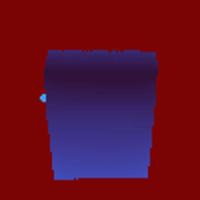

In [79]:
key = jax.random.split(key, 1)[0]
is_fork = jax.random.bernoulli(key)
key = jax.random.split(key, 1)[0]
shift = SHIFT_MIN + SHIFT_SCALE * jax.random.uniform(key)
print(shift, is_fork)
observation = fork_spoon_generator_jit(0.03, is_fork)
observation = observation[...,:3]
print(is_fork)
b.viz.scale_image(b.get_depth_image(observation[...,2]), 2)

0.10686222 False


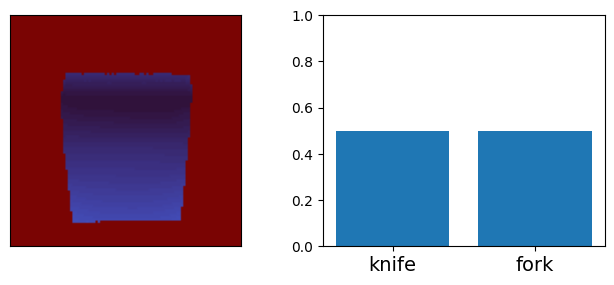

In [111]:
# pathlib.Path('knife_fork_results').mkdir(parents=True, exist_ok=True) 
# experiment_iteration = 0
# for experiment_iteration in tqdm(range(10)):
key = jax.random.split(key, 1)[0]
is_fork = jax.random.bernoulli(key)
key = jax.random.split(key, 1)[0]
shift = SHIFT_MIN + SHIFT_SCALE * jax.random.uniform(key)
print(shift, is_fork)
observation = fork_spoon_generator_jit(0.0, is_fork)
observation = observation[...,:3]

weight, trace = importance_jit(key, genjax.choice_map({
    "parent_0": -1,
    "parent_1": 0,
    "parent_2": 0,
    "id_0": jnp.int32(3),
    "id_1": jnp.int32(CHEESEITZ_BOX_IDX),
    "id_2": jnp.int32(FORK_IDX),
    "camera_pose": jnp.eye(4),
    "root_pose_0": table_pose,
    "face_parent_1": 2,
    "face_parent_2": 2,
    "face_child_1": 3,
    "face_child_2": 3,
    "variance": 0.001,
    "outlier_prob": 0.000001,
    "image": observation[...,:3],
    "contact_params_1": CHEESEITZ_BOX_CONTACT_PARAMS
    # "contact_params_1": jnp.array([0.0, 0.0, 0.0])
}), (
    jnp.arange(3),
    jnp.arange(4),
    jnp.array([-jnp.ones(3)*100.0, jnp.ones(3)*100.0]),
    jnp.array([jnp.array([-2.0, -2.1, -2*jnp.pi]), jnp.array([2.1, 2.1, 2*jnp.pi])]),
    b.RENDERER.model_box_dims, 1.0, intrinsics.fx)
)

trace = update_jit(key, trace, genjax.choice_map({"id_2": KNIFE_IDX}), b.make_unknown_change_argdiffs(trace))[2]
weights1 = enumerators[3](trace,key,contact_param_grid)
best_trace1 = enumerators[0](trace, key, contact_param_grid[weights1.argmax()])

trace = update_jit(key, trace, genjax.choice_map({"id_2": FORK_IDX}), b.make_unknown_change_argdiffs(trace))[2]
weights2 = enumerators[3](trace,key,contact_param_grid)
best_trace2 = enumerators[0](trace, key, contact_param_grid[weights2.argmax()])

fig = make_orientation_posterior_viz(observation, is_fork, b.utils.normalize_log_scores(jnp.array([weights1.max(), weights2.max()])))
fig.savefig(f'knife_fork_results/{experiment_iteration:05d}.png')


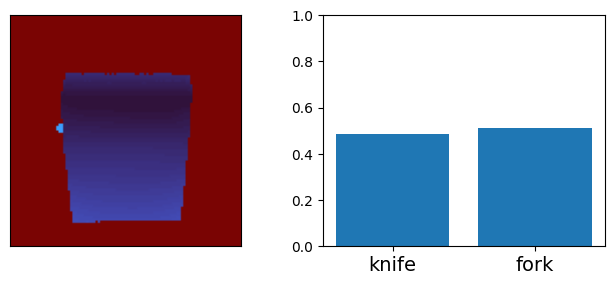

In [90]:
fig = make_orientation_posterior_viz(observation, is_fork, b.utils.normalize_log_scores(jnp.array([weights1.max(), weights2.max()])))
fig.savefig(f'knife_fork_results/{experiment_iteration:05d}.png')


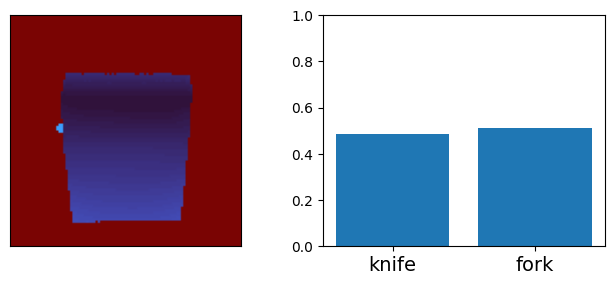

In [89]:
def make_orientation_posterior_viz(observation, is_fork, bars):
    f = plt.figure(figsize=(8,3))
    ax = f.add_subplot(121)
    ax2 = f.add_subplot(122)
    x = np.linspace(0,4,1000)
    
    ax.imshow(jnp.array(b.get_depth_image(observation[...,2])))
    ax.get_xaxis().set_visible(False)
    ax.get_yaxis().set_visible(False)
    # ax.set_title(f"Observation (params {gt_contact[0]:0.2f} {gt_contact[1]:0.2f} {gt_contact[2]:0.2f})")
    # ax.set_title(f"Observed Depth")
    
    
    ax2.bar(["knife", "fork"], bars)
    ax2.set_ylim(0.0, 1.0)
    ax2.set_xticks([0,1],labels=["knife", "fork"], fontsize=14)
    return f
f = make_orientation_posterior_viz(observation, is_fork, b.utils.normalize_log_scores(jnp.array([weights1.max(), weights2.max()])))


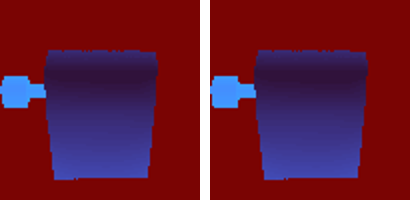

In [20]:
b.viz_trace_rendered_observed(best_trace1)

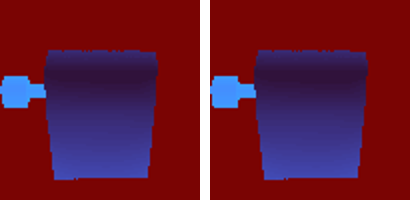

In [21]:
b.viz_trace_rendered_observed(best_trace2)